Size of Sigma: 5890
Size of D: 5947288
[[A10, A40, A70, A100, A130, A160, A190, A20, A50, A80, A110, A140, A170, A30, A60, A90, A120, A150, A180], [B100, B101, B102, B103, B104, B105, B106, B107, B108, B109, B1010, B1011, B1012, B1013, B1014, B1015, B1016, B1017, B1018, B1019, B1020, B200, B201, B202, B203, B204, B205, B206, B207, B208, B209, B2010, B2011, B2012, B2013, B2014, B2015, B2016, B2017, B2018, B2019, B2020, B300, B301, B302, B303, B304, B305, B306, B307, B308, B309, B3010, B3011, B3012, B3013, B3014, B3015, B3016, B3017, B3018, B3019, B3020, B400, B401, B402, B403, B404, B405, B406, B407, B408, B409, B4010, B4011, B4012, B4013, B4014, B4015, B4016, B4017, B4018, B4019, B4020, B500, B501, B502, B503, B504, B505, B506, B507, B508, B509, B5010, B5011, B5012, B5013, B5014, B5015, B5016, B5017, B5018, B5019, B5020, B600, B601, B602, B603, B604, B605, B606, B607, B608, B609, B6010, B6011, B6012, B6013, B6014, B6015, B6016, B6017, B6018, B6019, B6020, B700, B701, B702, B703, B704, 

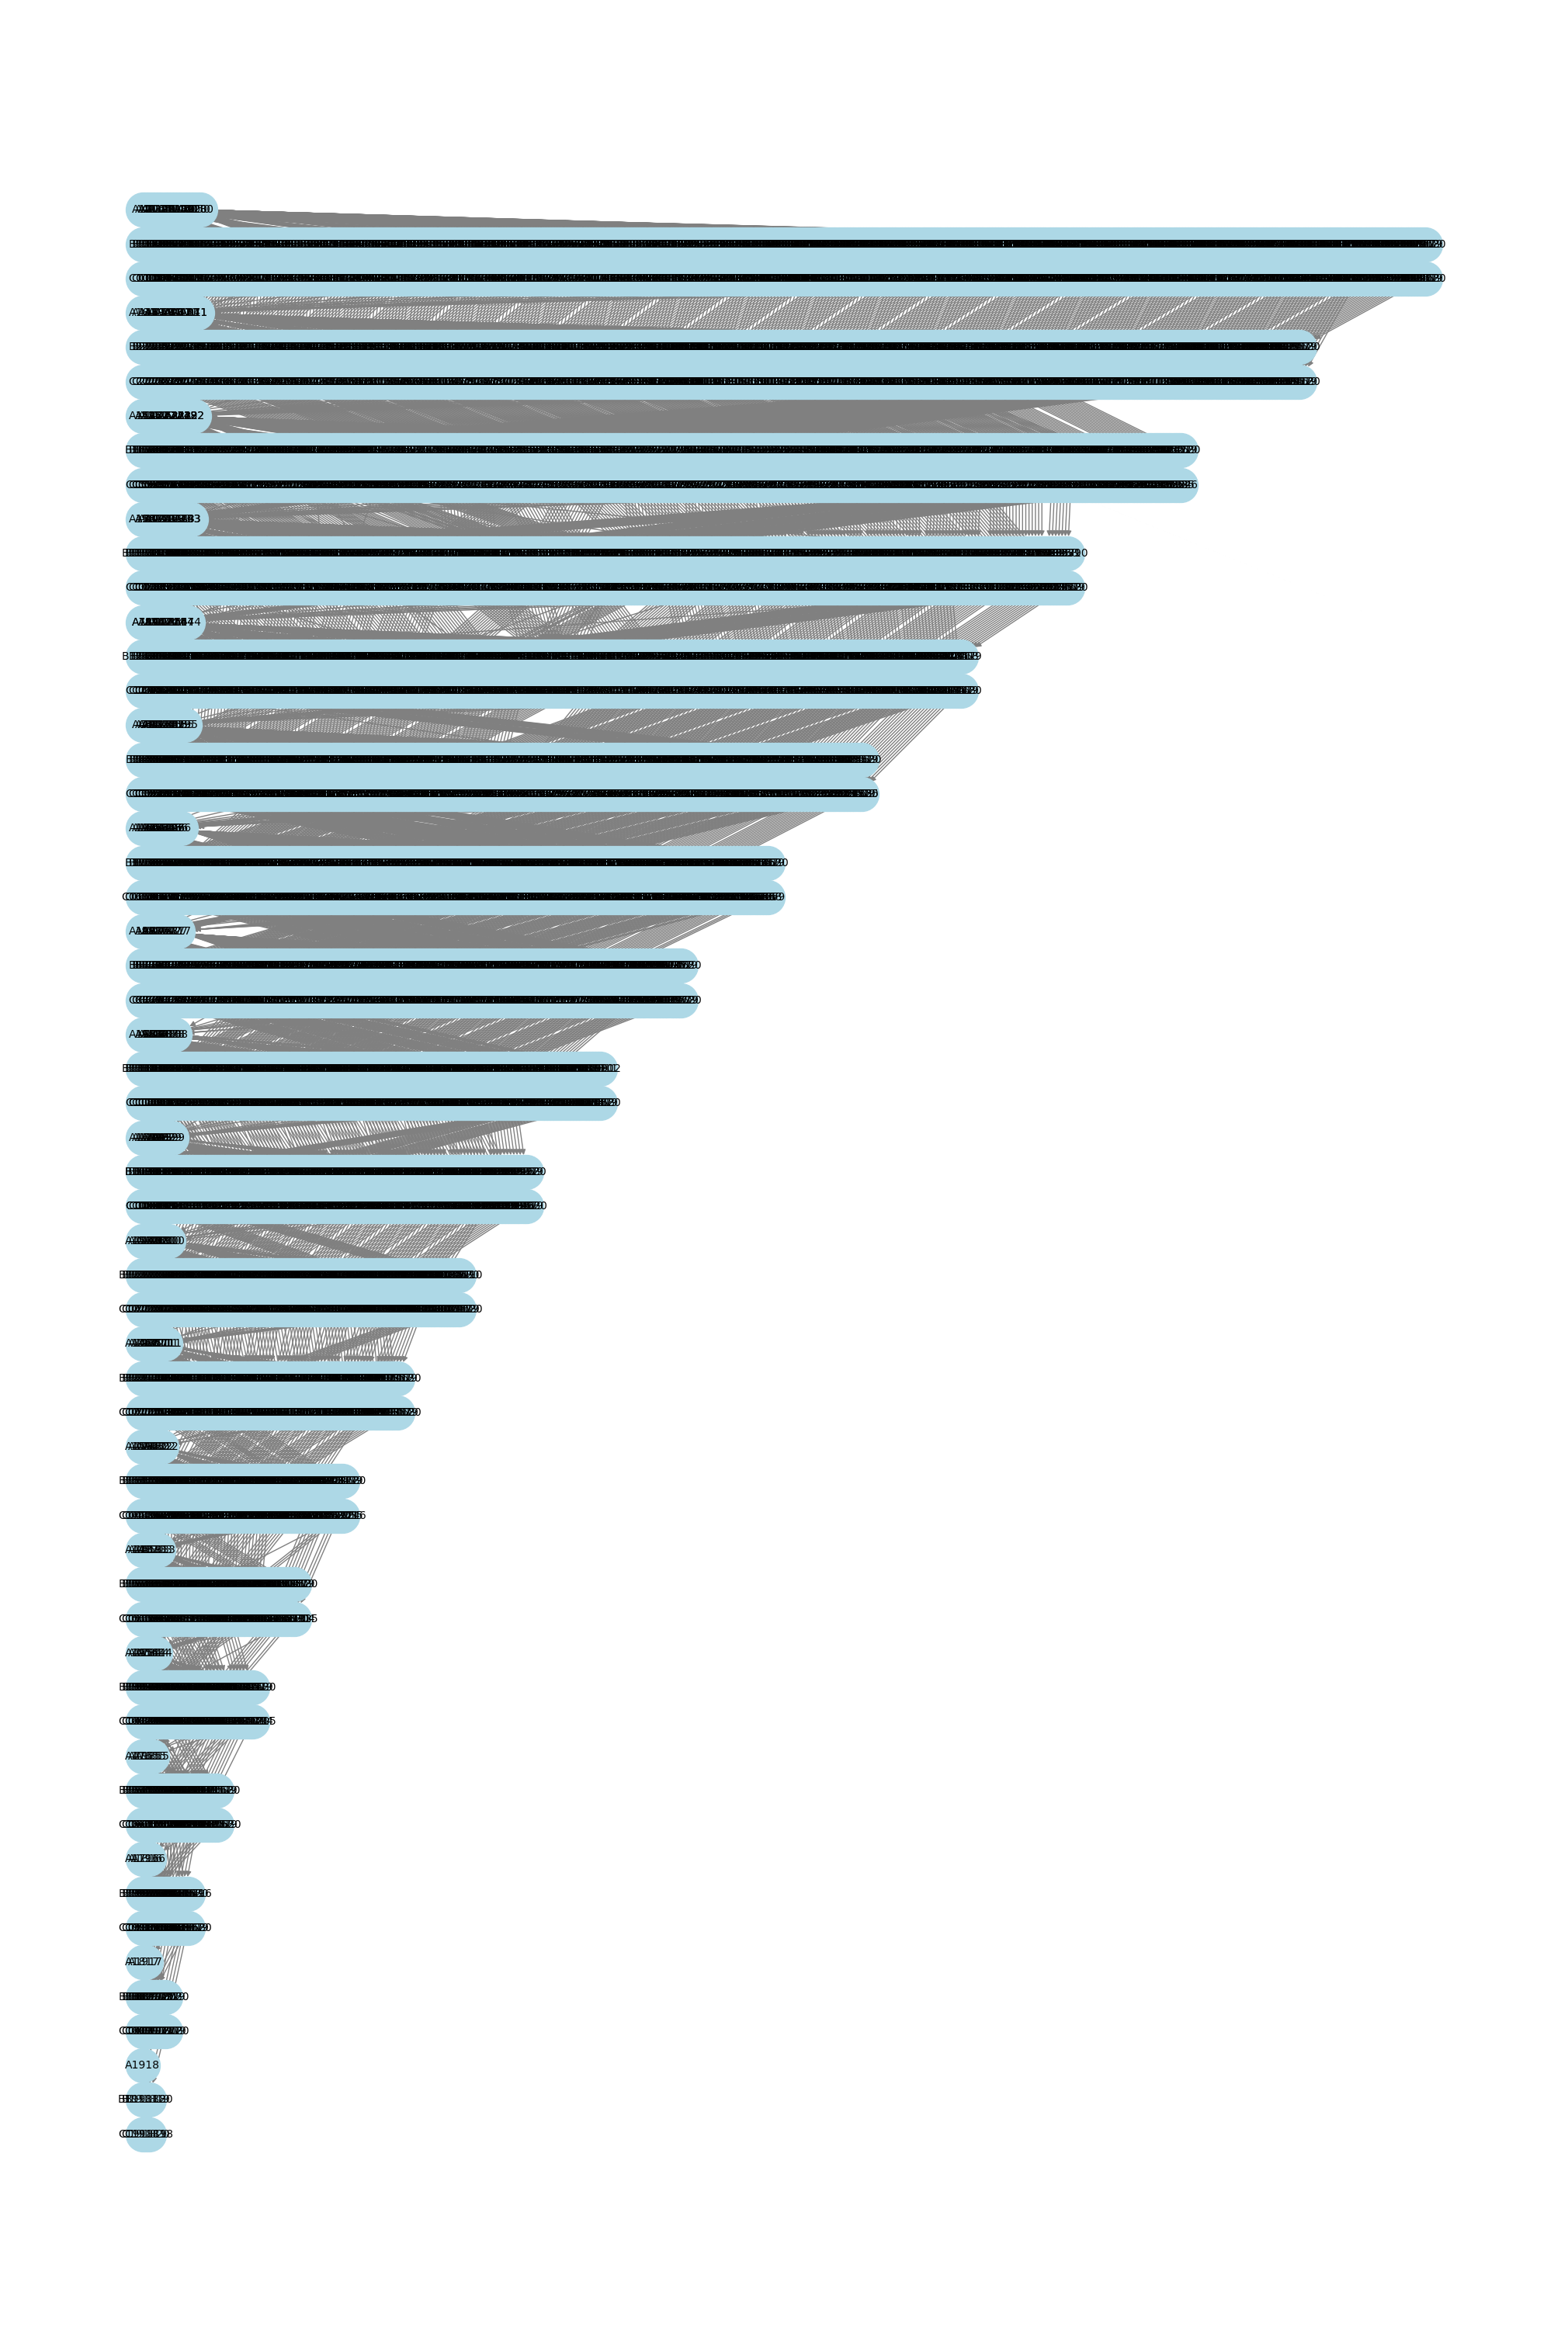

In [2]:
import networkx as nx 
import matplotlib.pyplot as plt
from copy import deepcopy

class Operation:
    def __init__(self, op_type, j, i, k=None) -> None:
        self.op_type = op_type
        self.j = j
        self.i = i
        self.k = k

    def __str__(self):
        return f"A{self.j}{self.i}" if self.op_type == "A" else f"{self.op_type}{self.j}{self.i}{self.k}"

    def __repr__(self):
        return f"A{self.j}{self.i}" if self.op_type == "A" else f"{self.op_type}{self.j}{self.i}{self.k}"

    def __eq__(self, other):
        if not isinstance(other, Operation):
            return False
        return other.op_type == self.op_type and other.j == self.j and other.i == self.i and other.k == self.k

    def __hash__(self):
        return hash((self.op_type, self.j, self.i, self.k))


def gen_sigma(N):
    sigma = set()

    for i in range(N):
        for j in range(i+1, N):
            sigma.add(Operation("A", j, i))
            for k in range(i, N+1):
                sigma.add(Operation("B", j, i, k))
                sigma.add(Operation("C", j, i, k))

    return sigma


def add_symmetry(D: set[tuple[Operation, Operation]]):
    to_add = set()
    for elem in D:
        to_add.add((elem[1], elem[0]))
    D.update(to_add)


def add_transitive_closure(D: set[tuple[Operation, Operation]]) -> set[tuple[Operation, Operation]]:
    def dfs(node, reachable):
        nonlocal Graph
        if node not in Graph:
            return
        for neighbour in Graph[node]:
            if neighbour not in reachable:
                reachable.add(neighbour)
                dfs(neighbour, reachable)

    Graph = dict()

    for (a, b) in D:
        Tab = Graph.get(a, [])
        Tab.append(b)
        Graph[a] = Tab

    closure = {node: set() for node in Graph}
    for node in Graph:
        dfs(node, closure[node])

    result = set()
    for node in closure:
        for reachable_node in closure[node]:
            result.add((node, reachable_node))

    return result


def gen_dependency_set(N):
    D = set()
    D1 = set()
    D2 = set()
    D3 = set()
    D4 = set()
    D5 = set()

    I_sigma = set()

    for i in range(N):
        for j in range(i+1, N):
            for k in range(i, N+1):
                D1.add((Operation("A", j, i), Operation("B", j, i, k)))
                D2.add((Operation("B", j, i, k), Operation("C", j, i, k)))

    for i in range(1, N):
        for j in range(i+1, N):
            for a in range(i):
                D3.add((Operation("C", j, a, i), Operation("A", j, i)))
                D3.add((Operation("C", i, a, i), Operation("A", j, i)))

    for i in range(1, N):
        for j in range(i+1, N):
            for k in range(i, N+1):
                for a in range(i):
                    D4.add((Operation("C", j, a, k), Operation("B", j, i, k)))

    for i in range(1, N):
        for j in range(i+1, N):
            for k in range(i, N+1):
                D5.add((Operation("C", j-1, i-1, k), Operation("C", j, i, k)))
                D5.add((Operation("C", j, i-1, k), Operation("C", j, i, k)))

    for elem in gen_sigma(N):
        I_sigma.add((elem, elem))

    D = D1 | D2 | D3 | D4 | D5

    D = add_transitive_closure(D)
    add_symmetry(D)

    return D | I_sigma


def gen_word(N):
    w = []
    for i in range(N-1):
        for j in range(i+1, N):

            w.append(Operation("A", j, i))
            for k in range(i, N+1):
                w.append(Operation("B", j, i, k))
            for k in range(i, N+1):
                w.append(Operation("C", j, i, k))

    return w


def gen_independency_set(Dependency_set: set, Sigma: set):
    # add everything that is not in D
    I = set()
    for elem1 in Sigma:
        for elem2 in Sigma:
            if (elem1, elem2) not in Dependency_set:
                I.add((elem1, elem2))
    return I


def createDependencyGraph(w, D):
    graph = [[] for _ in range(len(w))]
    for i in range(len(w)):
        for j in range(i+1, len(w)):
            if (w[i], w[j]) in D:
                graph[i].append(j)

    return graph


def reduceGraph(graph):
    n = len(graph)

    graph = [set(neighbors) for neighbors in graph]

    for u in range(n):
        to_remove = set()

        for v in graph[u]:
            to_remove.update(graph[u] & graph[v])

        graph[u] -= to_remove

    return [list(neighbors) for neighbors in graph]


def foatNormalForm(graph, w):
    graph2 = deepcopy(graph)
    result = []
    resultNumbers = []
    included = [False] * len(w)
    while False in included:
        fullset = {i for i in range(len(w)) if not included[i]}
        seen = set()
        for node in graph2:
            for v in node:
                seen.add(v)
        resultset = fullset - seen

        currFoat = []
        currArr = []
        for item in resultset:
            currArr.append(item)
            included[item] = True
            currFoat.append(w[item])
            graph2[item] = []

        result.append(currFoat)
        resultNumbers.append(currArr)

    return result, resultNumbers

def drawGraph(graph, w, FNF_helper):
    print(graph)
    G = nx.DiGraph()
    for i in range(len(graph)):
        G.add_node(i)
    for node, neighbors in enumerate(graph):
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    node_labels = {node: w[node] for node in range(len(w))}

    pos = {}

    for i in range(len(FNF_helper)):
        for j in range(len(FNF_helper[i])):
            pos[FNF_helper[i][j]] = (j, -1*i)

    plt.figure(figsize=(20, 30))

    nx.draw(
        G, pos, with_labels=False, node_color='lightblue', edge_color='gray',
        node_size=1000
    )

    nx.draw_networkx_labels(G, pos, labels=node_labels,
                            font_size=10, font_color='black')
    plt.axis('off')
    plt.show()

#print(gen_sigma(3))
N = 20
Sigma = gen_sigma(N)
D = gen_dependency_set(N)

w = gen_word(N)
print(f"Size of Sigma: {len(Sigma)}")
print(f"Size of D: {len(D)}")




G = reduceGraph(createDependencyGraph(w, D))
#print(G)

FNF, FNF_NUMBERS = foatNormalForm(G,w)
print(FNF)

I = gen_independency_set(D,Sigma)
print(f"Size of I: {len(I)}")

drawGraph(G,w,FNF_NUMBERS)
#gen_word(4)

In [2]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Matrix = torch.tensor([
    [2, 1, 3, 6],
    [4, 3, 8, 15],
    [6, 5, 16,27]
], dtype=torch.float32, device=device)

def manual_scheduler(Matrix, FNF):

    n, m = Matrix.shape

    m_Matrix = torch.zeros((n,m-2), device=Matrix.device)
    n_Matrix = torch.zeros_like(Matrix, device=Matrix.device)

    for block_id, block in enumerate(FNF):
        print(f"Executing Block {block_id + 1}: {block}")
        for op in block:
            op_type = op[0]
            if op_type == "A":
                j, i = int(op[1]), int(op[2])
                m_Matrix[j, i] =  Matrix[j, i] / Matrix[i, i]

            elif op_type == "B":
                j, i, k = int(op[1]), int(op[2]), int(op[3])
                n_Matrix[j, k] = Matrix[i, k] * m_Matrix[j, i]

            elif op_type == "C":
                j, i, k = int(op[1]), int(op[2]), int(op[3])
                Matrix[j, k] -= n_Matrix[j, k]

            else:
                raise ValueError(f"Unknown operation: {op[0]}")

        torch.cuda.synchronize()

    return Matrix

result = manual_scheduler(Matrix, FNF)

print("\nFinal Resultant Matrix:")
print(result.cpu().numpy())  

Executing Block 1: [A10, A40, A70, A100, A130, A160, A190, A20, A50, A80, A110, A140, A170, A30, A60, A90, A120, A150, A180]


TypeError: 'Operation' object is not subscriptable

Running for N = 2
Running for N = 3
Running for N = 4
Running for N = 5
Running for N = 6
Running for N = 7
Running for N = 8
Running for N = 9
Running for N = 10
Running for N = 11
Running for N = 12
Running for N = 13
Running for N = 14
Running for N = 15
Running for N = 16
Running for N = 17
Running for N = 18
Running for N = 19
Running for N = 20


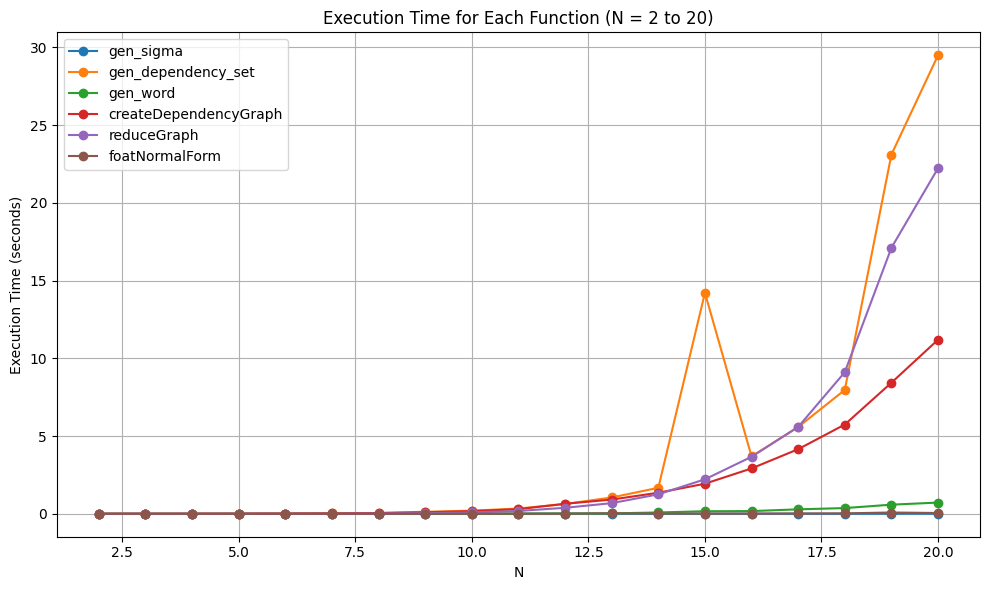

In [4]:
import time
import matplotlib.pyplot as plt

# Assuming that the functions are already defined somewhere in the code:
# gen_sigma, gen_dependency_set, gen_word, createDependencyGraph, reduceGraph, foatNormalForm

def measure_time_for_N_range(start=2, end=25):
    # Create lists to store the execution times for each function
    times_gen_sigma = []
    times_gen_dependency_set = []
    times_gen_word = []
    times_createDependencyGraph = []
    times_reduceGraph = []
    times_foatNormalForm = []
    
    # Loop through the range of N
    for N in range(start, end + 1):
        print(f"Running for N = {N}")

        # Measure time for gen_sigma
        start_time = time.time()
        Sigma = gen_sigma(N)
        end_time = time.time()
        times_gen_sigma.append(end_time - start_time)

        # Measure time for gen_dependency_set
        start_time = time.time()
        D = gen_dependency_set(N)
        end_time = time.time()
        times_gen_dependency_set.append(end_time - start_time)

        # Measure time for gen_word
        start_time = time.time()
        w = gen_word(N)
        end_time = time.time()
        times_gen_word.append(end_time - start_time)

        # Measure time for createDependencyGraph
        start_time = time.time()
        G = createDependencyGraph(w, D)
        end_time = time.time()
        times_createDependencyGraph.append(end_time - start_time)

        # Measure time for reduceGraph
        start_time = time.time()
        G_reduced = reduceGraph(G)
        end_time = time.time()
        times_reduceGraph.append(end_time - start_time)

        # Measure time for foatNormalForm
        start_time = time.time()
        FNF, FNF_NUMBERS = foatNormalForm(G_reduced, w)
        end_time = time.time()
        times_foatNormalForm.append(end_time - start_time)
        
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(start, end + 1), times_gen_sigma, label='gen_sigma', marker='o')
    plt.plot(range(start, end + 1), times_gen_dependency_set, label='gen_dependency_set', marker='o')
    plt.plot(range(start, end + 1), times_gen_word, label='gen_word', marker='o')
    plt.plot(range(start, end + 1), times_createDependencyGraph, label='createDependencyGraph', marker='o')
    plt.plot(range(start, end + 1), times_reduceGraph, label='reduceGraph', marker='o')
    plt.plot(range(start, end + 1), times_foatNormalForm, label='foatNormalForm', marker='o')

    # Adding labels and title
    plt.xlabel('N')
    plt.ylabel('Execution Time (seconds)')
    plt.title(f'Execution Time for Each Function (N = {start} to {end})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Run the timing measurements and plot the results
measure_time_for_N_range(2, 20)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [], [817, 858, 899, 940, 981, 1022, 1063, 1104, 1145, 1186, 1227, 1268, 1309, 1350, 1391, 1432, 1473, 1514], [839], [840], [841], [842], [843], [844], [845], [846], [847], [848], [849], [850], [851], [852], [853], [854], [855], [856], [857], [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [], [817, 879], [880, 819], [881, 820], [882, 821], [883, 822], [884, 823], [824, 885], [825, 886], [887, 826], [888, 827], [889, 828], [829, 890], [830, 891], [892, 831], [832, 893], [833, 894], [834, 895], [896, 835], [897, 836], [898, 837], [87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107], [108

KeyboardInterrupt: 

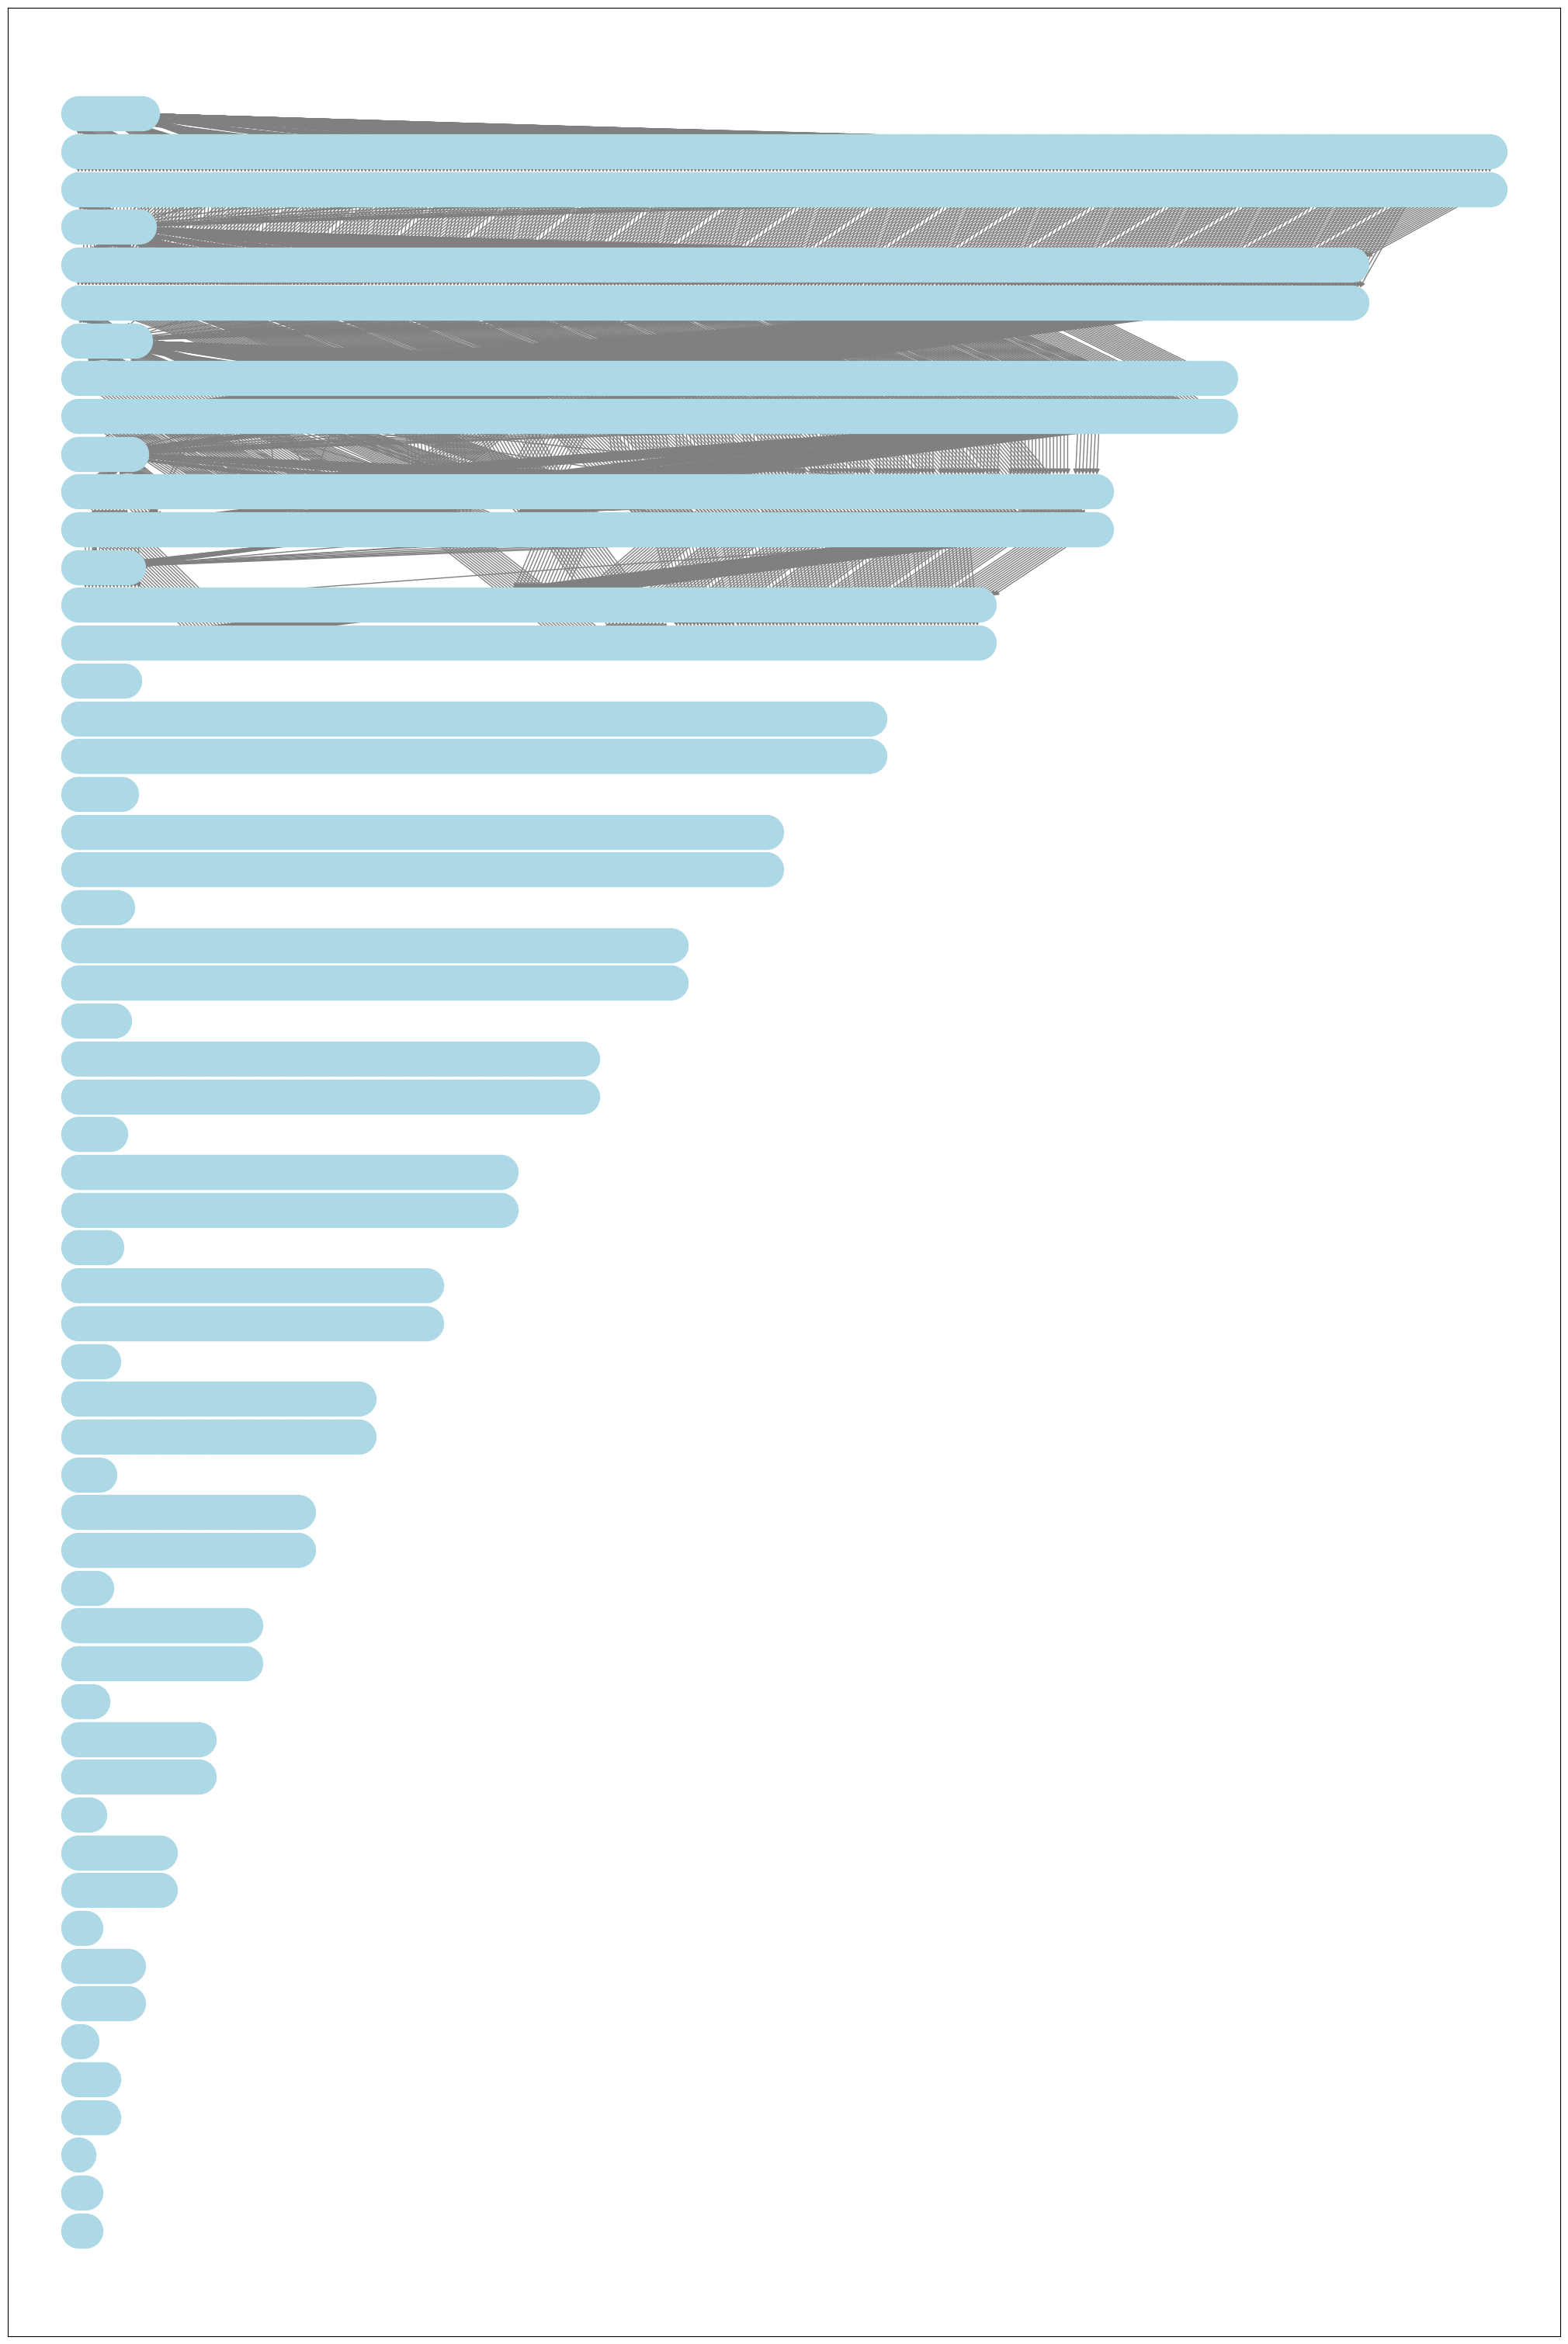

In [10]:
N = 20
Sigma = gen_sigma(N)
D = gen_dependency_set(N)

w = gen_word(N)
G = reduceGraph(createDependencyGraph(w, D))
FNF, FNF_NUMBERS = foatNormalForm(G,w)
drawGraph(G,w,FNF_NUMBERS)